In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.join(module_path, 'cnn-keras-update'))

In [2]:
%matplotlib inline

from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.regularizers import *
import keras.backend as K
import numpy as np

import fs
import models
from models.googlenet_custom_layers import PoolHelper, LRN
from transformation import get_normalization_transform
import utils
import plot_utils

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5103)
/usr/local/lib/python3.5/site-packages/Theano-0.8.2-py3.5.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
from dataset import ImdbWikiMultiDataset as Dataset

class_names = [[
    '[0 - 15]', '[16 - 20]', '[21 - 25]', '[26 - 30]', '[31 - 35]',
    '[36 - 40]', '[41 - 45]', '[46 - 50]', '[51 - 55]', '[56 - 100]'
],[
    'female',
    'male'
]]

n_classes = [10, 2]

shp = (3,112,112)

In [4]:
DATASET_DIR = '/data/imdb-wiki-dataset'

print("Loading %s ..." % type(Dataset).__name__)
# Initialize the datasets
ds_test = Dataset(DATASET_DIR, 'test')

print(" [%s] %i samples" % (ds_test.split, ds_test.size()))

Loading type ...
 [test] loading data block 0
 [test] loading data block 1
 [test] loading labels block 0
 [test] loading labels block 1
 [test] loading labels block 0
 [test] loading labels block 1
 [test] 65391 samples


In [5]:
print("Loading model")
# model = load_model('../cnn-keras-update/results/2017-01-20_12:58:44/best_model.h5',  custom_objects={"LRN": LRN})
model = load_model('../cnn-keras-update/results/2017-01-21_23:20:48/best_model.h5',  custom_objects={"LRN": LRN})

Loading model


In [6]:
# From the report txt
# Should be the same for all Nets
mean = np.array([ 0.45008409,  0.37675238,  0.3356632 ])
std = np.array([ 0.28836954,  0.26367465,  0.2598381 ])

def flip(X):
    return X.transpose((0,3,2,1))

def transform(X, mean=None, std=None):
    if std is not None:
        return flip((flip(X) - mean) / (std + 1e-8))
    elif mean is not None:
        return flip(flip(X) - mean)
    else:
        return X

X_test = transform(ds_test.samples(), mean, std)
Y_test_age = np_utils.to_categorical(ds_test.classes()[0], n_classes[0])
Y_test_gender = np_utils.to_categorical(ds_test.classes()[1], n_classes[1])

print('\nModel architecture:')
print(model.summary())

score = model.evaluate(X_test, [Y_test_age, Y_test_gender], verbose=0)

print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f/%.3f' % (score[3], score[4]))


Model architecture:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 112, 112)   0                                            
____________________________________________________________________________________________________
conv1_7x7 (Convolution2D)        (None, 96, 53, 53)    14208       input_1[0][0]                    
____________________________________________________________________________________________________
pool1_3x3 (MaxPooling2D)         (None, 96, 26, 26)    0           conv1_7x7[0][0]                  
____________________________________________________________________________________________________
norm1 (LRN)                      (None, 96, 26, 26)    0           pool1_3x3[0][0]                  
______________________________________________________________________

In [7]:
def predict_classes(model, x, batch_size=64, verbose=1):
    classes = []
    predictions = model.predict(x, batch_size=batch_size, verbose=verbose)
    for proba in predictions:
        if proba.shape[-1] > 1:
            classes.append(proba.argmax(axis=-1))
        else:
            classes.append((proba > 0.5).astype('int32'))
    return classes

In [8]:
from sklearn.metrics import confusion_matrix

print('Predicting the Age and Gender classes')
y_pred = predict_classes(model, X_test)

Predicting the Age and Gender classes
65391/65391 [==============================] - 56s     

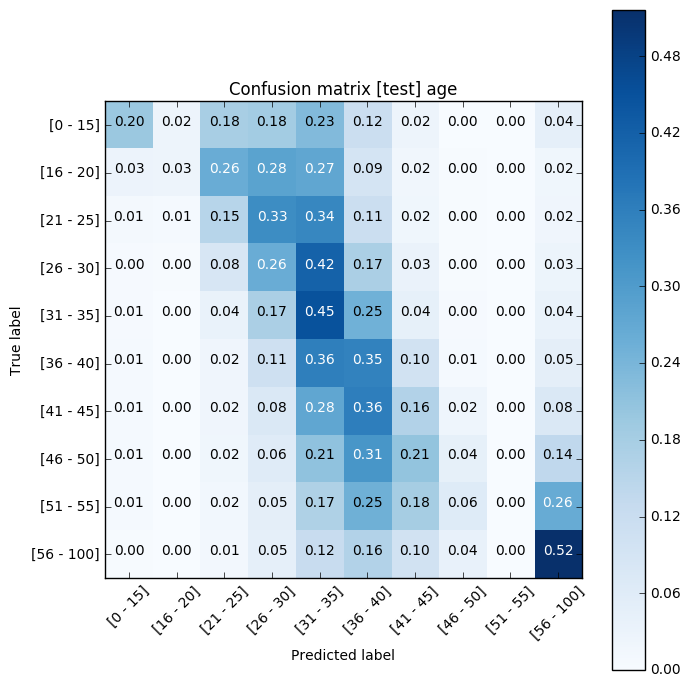

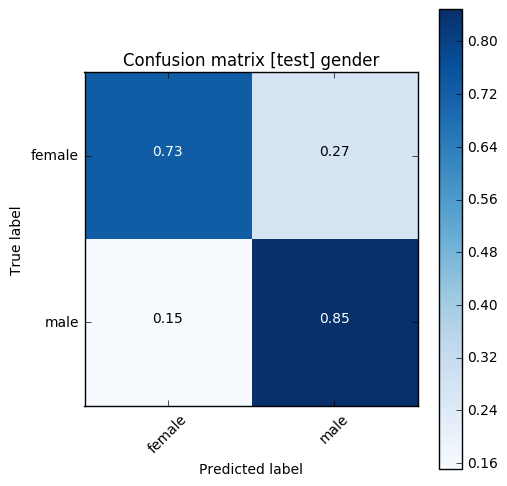

In [10]:
cm = confusion_matrix(ds_test.classes()[0], y_pred[0])
plot_utils.plot_confusion_matrix(cm, classes=class_names[0], normalize=True, title='Confusion matrix [test] age', figsize=(7,7))

cm = confusion_matrix(ds_test.classes()[1], y_pred[1])
plot_utils.plot_confusion_matrix(cm, classes=class_names[1], normalize=True, title='Confusion matrix [test] gender', figsize=(5,5))